# E) Unsupervised Learning (K-Means) 🟢🔵🔴
1) Feature set for behavior segmentation (e.g., studytime, absences, goout, freetime, famsup, schoolsup).

2) Select k using elbow and silhouette logic; justify choice.

3) Profile clusters (size, centroids, typical behaviors).

4) Compare average G3 (or pass rate) across clusters; interpret implications.

In [2]:
# Imports & load config/data
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import joblib

sns.set(style="whitegrid")

# Load config
with open("../artifacts/active_dataset.json", "r") as f:
    config = json.load(f)

active_dataset_name = config["active_dataset"]
processed_path = config["processed_path"]

# Load processed dataset (same one used in C/D)
df = pd.read_csv(processed_path)

print(f"Loaded processed dataset: {active_dataset_name}")
print("Shape:", df.shape)
display(df.head())

# Output folders
fig_dir = "../artifacts/figures"
os.makedirs(fig_dir, exist_ok=True)

km_dir = "../artifacts/kmeans"
os.makedirs(km_dir, exist_ok=True)


Loaded processed dataset: merged
Shape: (1044, 42)


,school_MS,sex_M,address_U,famsize_LE3,Pstatus_T,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_health,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4,3,4,1,1,3,6,5,6,6
1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,5,3,3,1,1,3,4,5,5,6
2,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,4,3,2,2,3,3,10,7,8,10
3,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,3,2,2,1,1,5,2,15,14,15
4,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,4,3,2,1,2,5,4,6,10,10


In [3]:
# Build behavior feature set (robust)
# We aim for: studytime, absences, goout, freetime, famsup, schoolsup
# After OneHotEncoder(drop='first'), binary columns likely look like *_yes
def pick_binary(df, base):
    # prefer one-hot column like "schoolsup_yes"
    cand = f"{base}_yes"
    if cand in df.columns:
        return cand
    # if raw categorical exists ('yes'/'no'), map to 1/0 on the fly
    if base in df.columns:
        # create temp numeric
        tmp = (df[base].astype(str).str.lower().eq("yes")).astype(int)
        new_name = f"{base}_yes_tmp"
        df[new_name] = tmp
        return new_name
    return None

feature_candidates = [
    "studytime",
    "absences",
    "goout",
    "freetime",
]

bin_famsup = pick_binary(df, "famsup")
bin_schoolsup = pick_binary(df, "schoolsup")

behavior_features = [c for c in feature_candidates if c in df.columns]
if bin_famsup: behavior_features.append(bin_famsup)
if bin_schoolsup: behavior_features.append(bin_schoolsup)

if len(behavior_features) < 3:
    # fallback: take any numeric columns that are present and relevant
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    # try to enrich with numeric proxies
    fallback = [c for c in ["studytime","absences","goout","freetime","G1","G2"] if c in numeric_cols]
    behavior_features = list(dict.fromkeys(behavior_features + fallback))[:6]  # cap size

print("Behavior features selected:", behavior_features)

# Keep a clean matrix (drop NA rows on selected features only)
X_raw = df[behavior_features].copy()
X_raw = X_raw.dropna(axis=0, how="any")
print("X_raw shape:", X_raw.shape)
display(X_raw.head())


Behavior features selected: ['studytime', 'absences', 'goout', 'freetime', 'famsup_yes', 'schoolsup_yes']
X_raw shape: (1044, 6)


,studytime,absences,goout,freetime,famsup_yes,schoolsup_yes
0,2,6,4,3,0.0,1.0
1,2,4,3,3,1.0,0.0
2,2,10,2,3,0.0,1.0
3,3,2,2,2,1.0,0.0
4,2,4,2,3,1.0,0.0


In [4]:
# Scale features
scaler = StandardScaler()
X = scaler.fit_transform(X_raw.values)

print("Scaled feature matrix shape:", X.shape)

# Save the scaler for reproducibility
scaler_path = os.path.join(km_dir, f"{active_dataset_name}_kmeans_scaler.pkl")
joblib.dump(scaler, scaler_path)
print("Saved scaler:", scaler_path)


Scaled feature matrix shape: (1044, 6)
Saved scaler: ../artifacts/kmeans\merged_kmeans_scaler.pkl


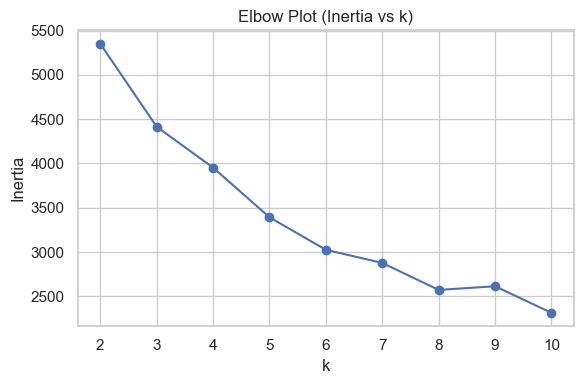

Saved: ../artifacts/figures\merged_kmeans_elbow.png


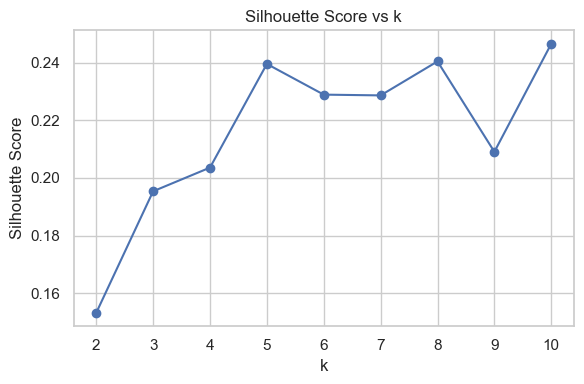

Saved: ../artifacts/figures\merged_kmeans_silhouette.png
Auto-selected k (max silhouette): 10


In [5]:
# Elbow & Silhouette
K_RANGE = list(range(2, 11))
inertias = []
sil_scores = []

for k in K_RANGE:
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = km.fit_predict(X)
    inertias.append(km.inertia_)
    sil = silhouette_score(X, labels)
    sil_scores.append(sil)

# Plot elbow (inertia)
plt.figure(figsize=(6,4))
plt.plot(K_RANGE, inertias, marker="o")
plt.title("Elbow Plot (Inertia vs k)")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.tight_layout()
elbow_path = os.path.join(fig_dir, f"{active_dataset_name}_kmeans_elbow.png")
plt.savefig(elbow_path, dpi=150)
plt.show()
print("Saved:", elbow_path)

# Plot silhouette
plt.figure(figsize=(6,4))
plt.plot(K_RANGE, sil_scores, marker="o")
plt.title("Silhouette Score vs k")
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.tight_layout()
sil_path = os.path.join(fig_dir, f"{active_dataset_name}_kmeans_silhouette.png")
plt.savefig(sil_path, dpi=150)
plt.show()
print("Saved:", sil_path)

# Choose k by best silhouette (you can override manually if you want)
best_k = K_RANGE[int(np.argmax(sil_scores))]
print(f"Auto-selected k (max silhouette): {best_k:.0f}")


In [6]:
# Fit final model & save artifacts
kmeans = KMeans(n_clusters=int(best_k), random_state=42, n_init="auto")
cluster_labels = kmeans.fit_predict(X)

# Save model
model_path = os.path.join(km_dir, f"{active_dataset_name}_kmeans_model_k{best_k}.pkl")
joblib.dump(kmeans, model_path)
print("Saved KMeans model:", model_path)

# Attach labels to a copy aligned with X_raw index
df_clusters = df.loc[X_raw.index].copy()
df_clusters["cluster"] = cluster_labels

# Save cluster-annotated dataset
clusters_csv = os.path.join(km_dir, f"{active_dataset_name}_kmeans_clusters_k{best_k}.csv")
df_clusters.to_csv(clusters_csv, index=False)
print("Saved clusters CSV:", clusters_csv)

display(df_clusters.head())


Saved KMeans model: ../artifacts/kmeans\merged_kmeans_model_k10.pkl
Saved clusters CSV: ../artifacts/kmeans\merged_kmeans_clusters_k10.csv


,school_MS,sex_M,address_U,famsize_LE3,Pstatus_T,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_health,...,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,cluster
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3,4,1,1,3,6,5,6,6,2
1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,3,3,1,1,3,4,5,5,6,1
2,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,3,2,2,3,3,10,7,8,10,2
3,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,2,2,1,1,5,2,15,14,15,1
4,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,3,2,1,2,5,4,6,10,10,1


In [7]:
# Profile clusters
sizes = df_clusters["cluster"].value_counts().sort_index()
print("Cluster sizes:")
display(sizes.to_frame("count"))

# Centroids in scaled space
centroids_scaled = kmeans.cluster_centers_

# Inverse-transform to original feature space (relative to scaler)
centroids_original = scaler.inverse_transform(centroids_scaled)
centers_df = pd.DataFrame(
    centroids_original, 
    columns=behavior_features
)
centers_df.insert(0, "cluster", range(centers_df.shape[0]))

print("Cluster centroids (original units relative to selected features):")
display(centers_df)

# Save profiles
sizes_csv = os.path.join(km_dir, f"{active_dataset_name}_kmeans_cluster_sizes_k{best_k}.csv")
centers_csv = os.path.join(km_dir, f"{active_dataset_name}_kmeans_centroids_k{best_k}.csv")
sizes.to_frame("count").to_csv(sizes_csv)
centers_df.to_csv(centers_csv, index=False)
print("Saved:", sizes_csv)
print


Cluster sizes:


,count
cluster,
0,123
1,200
2,117
3,103
4,5
5,64
6,85
7,118
8,64


Cluster centroids (original units relative to selected features):


,cluster,studytime,absences,goout,freetime,famsup_yes,schoolsup_yes
0,0,1.577236,4.024390,4.495935,3.853659,-1.110223e-16,-9.714451e-17
1,1,1.780000,2.760000,2.430000,2.645000,1.000000e+00,-8.326673e-17
2,2,2.136752,3.666667,2.974359,3.128205,7.264957e-01,1.000000e+00
3,3,1.349515,3.213592,2.446602,2.058252,0.000000e+00,-8.326673e-17
4,4,2.000000,52.600000,2.600000,2.200000,6.000000e-01,2.000000e-01
5,5,1.546875,3.125000,2.187500,4.468750,2.031250e-01,-5.551115e-17
6,6,2.847059,3.082353,2.600000,2.929412,-2.220446e-16,-8.326673e-17
7,7,3.313559,3.161017,3.203390,3.305085,1.000000e+00,-9.714451e-17
8,8,1.687500,17.421875,3.421875,3.015625,8.750000e-01,1.562500e-02
9,9,1.624242,3.696970,4.151515,3.830303,1.000000e+00,-9.714451e-17


Saved: ../artifacts/kmeans\merged_kmeans_cluster_sizes_k10.csv


<function print(*args, sep=' ', end='\n', file=None, flush=False)>

Average G3 by cluster:


cluster
0    10.495935
1    11.355000
2    10.521368
3    11.378641
4     9.400000
5    12.156250
6    12.282353
7    12.872881
8    10.703125
9    10.927273
Name: G3, dtype: float64


Pass rate by cluster:


cluster
0    0.715447
1    0.805000
2    0.743590
3    0.786408
4    0.400000
5    0.843750
6    0.882353
7    0.847458
8    0.656250
9    0.751515
Name: pass_, dtype: float64

Saved: ../artifacts/kmeans_cluster_performance.csv


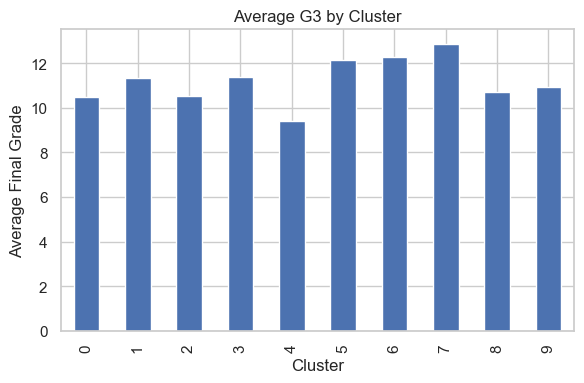

In [8]:
# Compare Clusters on G3 and Pass Rate

# Attach cluster labels to original df
df_clusters = df.copy()
df_clusters["cluster"] = kmeans.labels_

# Mean G3 per cluster
print("Average G3 by cluster:")
g3_means = df_clusters.groupby("cluster")["G3"].mean()
display(g3_means)

# Pass rate (G3 >= 10) per cluster
print("\nPass rate by cluster:")
pass_rate = df_clusters.assign(pass_=df_clusters["G3"] >= 10) \
                       .groupby("cluster")["pass_"].mean()
display(pass_rate)

# Save comparisons
comparison = pd.DataFrame({
    "avg_G3": g3_means,
    "pass_rate": pass_rate
})
comparison.to_csv("../artifacts/kmeans_cluster_performance.csv")
print("Saved: ../artifacts/kmeans_cluster_performance.csv")

# Plot average G3 per cluster
comparison["avg_G3"].plot(kind="bar", figsize=(6,4))
plt.title("Average G3 by Cluster")
plt.ylabel("Average Final Grade")
plt.xlabel("Cluster")
plt.tight_layout()
plt.savefig("../artifacts/figures/kmeans_avgG3_by_cluster.png")
plt.show()


In [9]:
# Save dataset with cluster labels

df_clusters.to_csv("../artifacts/dataset_with_clusters.csv", index=False)
print("Saved dataset with cluster labels: ../artifacts/dataset_with_clusters.csv")

display(df_clusters.head())


Saved dataset with cluster labels: ../artifacts/dataset_with_clusters.csv


,school_MS,sex_M,address_U,famsize_LE3,Pstatus_T,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_health,...,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,cluster
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3,4,1,1,3,6,5,6,6,2
1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,3,3,1,1,3,4,5,5,6,1
2,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,3,2,2,3,3,10,7,8,10,2
3,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,2,2,1,1,5,2,15,14,15,1
4,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,3,2,1,2,5,4,6,10,10,1


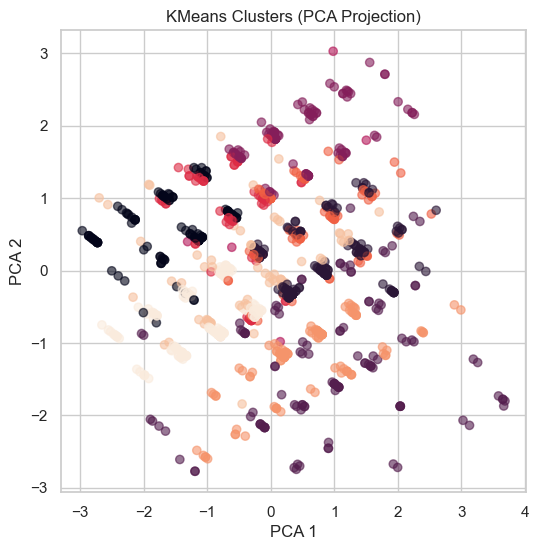

In [11]:
# Visualize Clusters with PCA (2D projection)

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Define the same features we used for KMeans
features = ["studytime", "absences", "goout", "freetime", "famsup_yes", "schoolsup_yes"]
X = df[features].copy()

# Scale data again (needed for PCA)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reduce to 2D for visualization
pca = PCA(n_components=2)
reduced = pca.fit_transform(X_scaled)

plt.figure(figsize=(6,6))
plt.scatter(reduced[:,0], reduced[:,1], c=kmeans.labels_, alpha=0.6)
plt.title("KMeans Clusters (PCA Projection)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.savefig("../artifacts/figures/kmeans_clusters_pca.png")
plt.show()


In [14]:
# Interpretation of clusters
import numpy as np

overall_means = df_clusters[["studytime", "absences", "goout", "freetime", "G3"]].mean()

def interpret_cluster(row, overall_means):
    interpretation = []
    
    # Compare each feature with overall mean
    if row["studytime"] > overall_means["studytime"] + 0.5:
        interpretation.append("high study commitment")
    elif row["studytime"] < overall_means["studytime"] - 0.5:
        interpretation.append("low study commitment")
    
    if row["absences"] > overall_means["absences"] * 2:
        interpretation.append("very high absences")
    elif row["absences"] < overall_means["absences"] * 0.5:
        interpretation.append("low absences")
    
    if row["goout"] > overall_means["goout"] + 0.7:
        interpretation.append("very social (goes out often)")
    elif row["goout"] < overall_means["goout"] - 0.7:
        interpretation.append("less social")
    
    if row["freetime"] > overall_means["freetime"] + 0.7:
        interpretation.append("lots of free time")
    elif row["freetime"] < overall_means["freetime"] - 0.7:
        interpretation.append("little free time")
    
    if row["G3"] > overall_means["G3"] + 1:
        interpretation.append("strong academic results")
    elif row["G3"] < overall_means["G3"] - 1:
        interpretation.append("weak academic results")
    
    if not interpretation:
        return "Typical/average behavior"
    else:
        return ", ".join(interpretation)

# Apply interpretation to cluster profiles
cluster_profiles = df_clusters.groupby("cluster")[["studytime","absences","goout","freetime","G3"]].mean().reset_index()
cluster_profiles["Interpretation"] = cluster_profiles.apply(lambda r: interpret_cluster(r, overall_means), axis=1)

# Print results
for _, row in cluster_profiles.iterrows():
    print(f"Cluster {int(row['cluster'])}:")
    print(f" - Avg Studytime: {row['studytime']:.2f}")
    print(f" - Avg Absences: {row['absences']:.2f}")
    print(f" - Avg Goout: {row['goout']:.2f}")
    print(f" - Avg Freetime: {row['freetime']:.2f}")
    print(f" - Avg Final Grade (G3): {row['G3']:.2f}")
    print(f" → Interpretation: {row['Interpretation']}\n")

# Save profiles
profiles_path = "../artifacts/processed/cluster_profiles.csv"
import os
os.makedirs(os.path.dirname(profiles_path), exist_ok=True)
cluster_profiles.to_csv(profiles_path, index=False)
print(f"\nCluster profiles saved to {profiles_path}")


Cluster 0:
 - Avg Studytime: 1.58
 - Avg Absences: 4.02
 - Avg Goout: 4.50
 - Avg Freetime: 3.85
 - Avg Final Grade (G3): 10.50
 → Interpretation: very social (goes out often)

Cluster 1:
 - Avg Studytime: 1.78
 - Avg Absences: 2.76
 - Avg Goout: 2.43
 - Avg Freetime: 2.65
 - Avg Final Grade (G3): 11.36
 → Interpretation: less social

Cluster 2:
 - Avg Studytime: 2.14
 - Avg Absences: 3.67
 - Avg Goout: 2.97
 - Avg Freetime: 3.13
 - Avg Final Grade (G3): 10.52
 → Interpretation: Typical/average behavior

Cluster 3:
 - Avg Studytime: 1.35
 - Avg Absences: 3.21
 - Avg Goout: 2.45
 - Avg Freetime: 2.06
 - Avg Final Grade (G3): 11.38
 → Interpretation: low study commitment, less social, little free time

Cluster 4:
 - Avg Studytime: 2.00
 - Avg Absences: 52.60
 - Avg Goout: 2.60
 - Avg Freetime: 2.20
 - Avg Final Grade (G3): 9.40
 → Interpretation: very high absences, little free time, weak academic results

Cluster 5:
 - Avg Studytime: 1.55
 - Avg Absences: 3.12
 - Avg Goout: 2.19
 - Avg 